In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import gsw

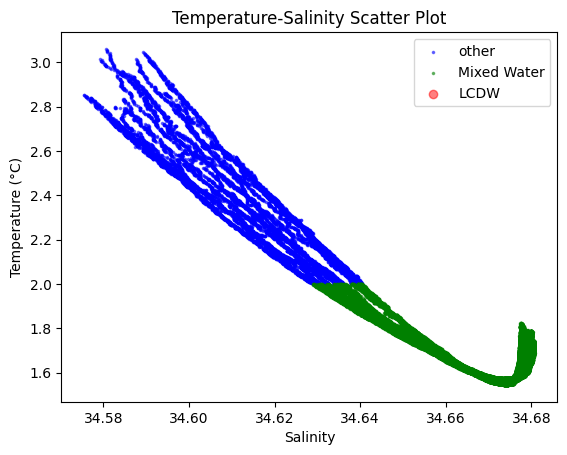

In [2]:
def plot_ts_scatter(folder_path):
    all_data_frames = []  # 创建一个列表来收集所有DataFrame

    # 获取文件夹内所有的Excel文件
    excel_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.xlsx') and not f.startswith('~$')]

    # 循环读取所有文件
    for file in excel_files:
        df = pd.read_excel(file, sheet_name=0, skiprows=3)  # 假设数据从第四行开始
        all_data_frames.append(df)

    # 合并所有DataFrame到一个大的DataFrame
    all_data = pd.concat(all_data_frames, ignore_index=True)

    # 选取第12列为水温，第14列为盐度,第10列为深度
    depth = all_data.iloc[:, 9]
    temperature = all_data.iloc[:, 11]
    salinity = all_data.iloc[:, 13]

    # 根据水温划分水团
    mixed_water = all_data[(temperature >= 1.2) & (temperature <= 2.0)]
    lcdw = all_data[temperature < 1.2]
    other = all_data[(temperature >= 2.0) & (depth >= 1500)]

    # 绘制散点图
    plt.scatter(other.iloc[:, 13], other.iloc[:, 11], c='blue', alpha=0.5,  label='other',s=2.5 )
    plt.scatter(mixed_water.iloc[:, 13], mixed_water.iloc[:, 11], c='green', label='Mixed Water', alpha=0.5 , s=2.5)
    plt.scatter(lcdw.iloc[:, 13], lcdw.iloc[:, 11], c='red', label='LCDW', alpha=0.5)

    # 添加图例
    plt.legend()

    # 添加标题和坐标轴标签
    plt.title('Temperature-Salinity Scatter Plot')
    plt.xlabel('Salinity')
    plt.ylabel('Temperature (°C)')

    # 显示图表
    plt.show()

# 文件夹路径
folder_path = r'C:\Users\12716\Desktop\CTD\根据地理位置对站点分区\Philippine Basin'
plot_ts_scatter(folder_path)


              0         1        2        3
2056   2044.171  1.999562  34.6167  10.9017
2057   2045.155  1.998492  34.6168  10.9017
2058   2046.140  1.997717  34.6170  10.9017
2059   2047.124  1.996746  34.6168  10.9017
2060   2048.109  1.996562  34.6168  10.9017
...         ...       ...      ...      ...
25814  3807.357  1.201796  34.6648  10.8167
25815  3808.334  1.201299  34.6649  10.8167
25816  3809.311  1.200705  34.6650  10.8167
25817  3810.287  1.200695  34.6650  10.8167
25818  3811.264  1.200296  34.6651  10.8167

[8857 rows x 4 columns]


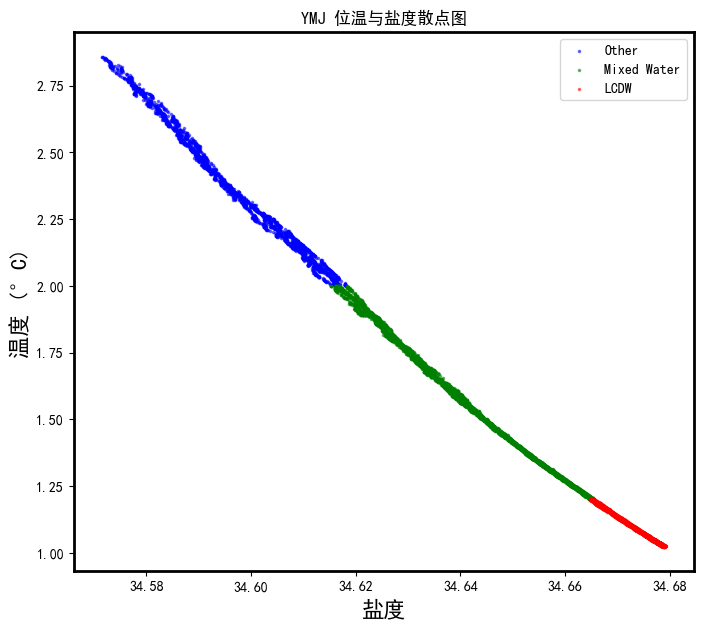

In [24]:
def plot_ts_scatter(folder_path):
    # 创建一个列表来收集所有水温、盐度和深度数据
    all_temperatures = []
    all_salinities = []
    all_depths = []
    all_latitude_dd = []

    # 获取文件夹内所有的 Excel 文件
    excel_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.xlsx') and not f.startswith('~$')]

    # 循环读取所有文件
    for file in excel_files:
        df = pd.read_excel(file, sheet_name=0, skiprows=5)  # 假设数据从第六行开始
        depth = df.iloc[:, 9]
        temperature = df.iloc[:, 11]
        salinity = df.iloc[:, 13]
        latitude_dd = df.iloc[:, 5]

        # 将每个文件的数据添加到列表中
        all_depths.append(depth)
        all_temperatures.append(temperature)
        all_salinities.append(salinity)
        all_latitude_dd.append(latitude_dd)

    # 合并所有文件的数据
    depth = pd.concat(all_depths, ignore_index=True)
    temperature = pd.concat(all_temperatures, ignore_index=True)
    salinity = pd.concat(all_salinities, ignore_index=True)
    latitude_dd = pd.concat(all_latitude_dd, ignore_index=True)

    pressure = gsw.p_from_z(-depth, latitude_dd)
    potential_temp = gsw.pt0_from_t(salinity, temperature, pressure)

    # 根据水温划分水团
    mixed_water = pd.concat([depth, potential_temp, salinity, latitude_dd], axis=1)[(potential_temp >= 1.2) & (potential_temp <= 2.0)]
    lcdw = pd.concat([depth, potential_temp, salinity, latitude_dd], axis=1)[potential_temp < 1.2]
    other = pd.concat([depth, potential_temp, salinity, latitude_dd], axis=1)[(potential_temp >= 2.0) & (depth >= 1500)]

    print(mixed_water)

    ax = plt.figure(figsize=(8,7))
    # 绘制散点图
    plt.scatter(other[2], other[1], c='blue', alpha=0.5,  label='Other',s=2.5 )
    plt.scatter(mixed_water[2], mixed_water[1], c='green', label='Mixed Water', alpha=0.5 , s=2.5)
    plt.scatter(lcdw[2], lcdw[1], c='red', label='LCDW', alpha=0.5, s=2.5)

    # 添加图例
    plt.legend()

    # 添加标题和坐标轴标签
    plt.title('YMJ 位温与盐度散点图')
    plt.xlabel('盐度', fontsize=16)
    plt.ylabel('温度 (°C)',fontsize=16)

    plt.gca().spines['top'].set_linewidth(2)  # 加粗上边框
    plt.gca().spines['right'].set_linewidth(2)  # 加粗右边框
    plt.gca().spines['bottom'].set_linewidth(2)  # 加粗下边框
    plt.gca().spines['left'].set_linewidth(2)  # 加粗左边框

    # 显示图表
    plt.show()

# 文件夹路径
folder_path = r'C:\Users\12716\Desktop\CTD\根据地理位置对站点分区\FMJ'
plot_ts_scatter(folder_path)


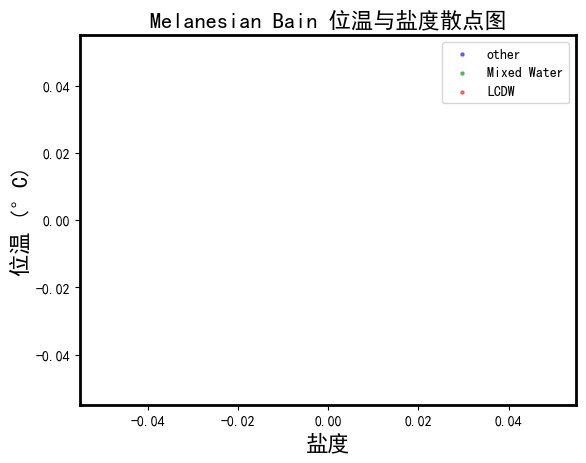

In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import gsw  # 导入 Gibbs Seawater 库
import re
from matplotlib.patches import Rectangle

plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows下使用SimHei字体
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

def dms_to_dd(dms):
    """将度分秒格式的纬度或经度字符串转换为十进制度格式。
    示例输入: '07°59′99"N' 或可能已经是十进制格式。
    """
    if not isinstance(dms, str):
        return dms  # 如果输入不是字符串，直接返回原值，假设它已经是数值格式。

    pattern = r"(\d+)°(\d+)′(\d+)(?:″|'')?([NSEW])"
    match = re.match(pattern, dms)
    if match:
        degrees, minutes, seconds, direction = match.groups()
        decimal_degree = float(degrees) + float(minutes) / 60 + float(seconds) / 3600
        if direction in 'SW':
            decimal_degree = -decimal_degree
        return decimal_degree
    else:
        return None  # 如果格式不匹配，返回None或其他合适的值

def plot_ts_scatter(folder_path):
    all_data_frames = []

    excel_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.xlsx') and not f.startswith('~$')]

    for file in excel_files:
        df = pd.read_excel(file, sheet_name=0, skiprows=3)
        all_data_frames.append(df)

    all_data = pd.concat(all_data_frames, ignore_index=True)

    depth = all_data.iloc[:, 9]
    temperature = all_data.iloc[:, 11]
    salinity = all_data.iloc[:, 13]
    latitude = all_data.iloc[:, 5]

    latitude_dd = latitude.apply(lambda x: dms_to_dd(x) if isinstance(x, str) else x)
    latitude_dd = pd.to_numeric(latitude_dd, errors='coerce')

    valid_data = all_data[~latitude_dd.isna() & ~depth.isna()]
    depth = valid_data[depth.name]
    salinity = valid_data[salinity.name]
    temperature = valid_data[temperature.name]
    latitude_dd = valid_data[latitude_dd.name]

    pressure = [gsw.p_from_z(-d, lat) for d, lat in zip(depth, latitude_dd)]
    potential_temp = gsw.pt0_from_t(salinity, temperature, pressure)

    mixed_water = valid_data[(potential_temp >= 1.2) & (potential_temp <= 2.0)]
    lcdw = valid_data[potential_temp < 1.2]
    other = valid_data[(potential_temp >= 2.0) & (depth >= 1500)]

    fig, ax = plt.subplots()
    ax.scatter(other[salinity.name], potential_temp[other.index], c='blue', alpha=0.5, label='other', s=5)
    ax.scatter(mixed_water[salinity.name], potential_temp[mixed_water.index], c='green', label='Mixed Water', alpha=0.5, s=5)
    ax.scatter(lcdw[salinity.name], potential_temp[lcdw.index], c='red', label='LCDW', alpha=0.5, s=5)
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    
    plt.legend()
    ax.set_title('Melanesian Bain 位温与盐度散点图', fontsize=16)
    # ax.set_xticks()
    ax.set_xlabel('盐度', fontsize=16)
    ax.set_ylabel('位温 (°C)', fontsize=16)
    plt.show()

folder_path = r'C:\Users\12716\Desktop\CTD\根据地理位置对站点分区\Melanesian Bain'
plot_ts_scatter(folder_path)
